In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Embedding, GlobalAveragePooling1D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
bbc = pd.read_csv('/content/bbc-text.csv')

In [ ]:
bbc.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
bbc.shape

(2225, 2)

In [ ]:
bbc.isna().sum()

,0
category,0
text,0


In [ ]:
bbc.duplicated().sum()

99

In [ ]:
bbc = bbc.drop_duplicates()

# Check class balance

In [ ]:
counts= bbc['category'].value_counts()
counts

,count
category,
sport,504
business,503
politics,403
entertainment,369
tech,347


In [ ]:
len(counts)

5

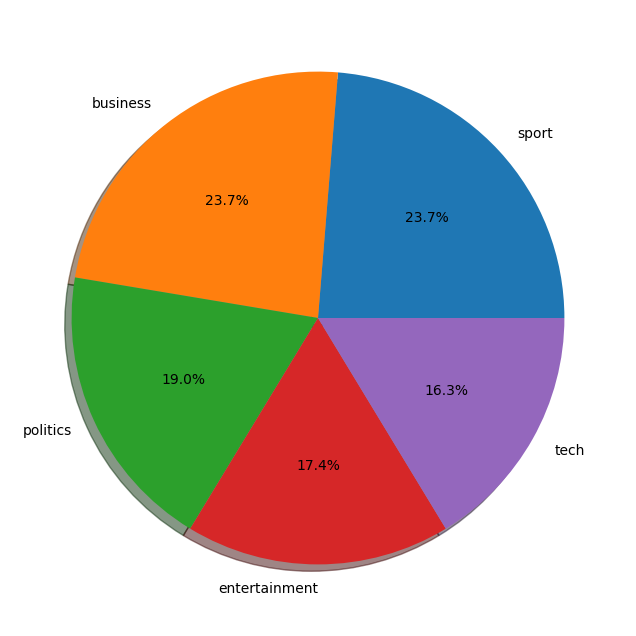

In [ ]:
plt.figure(figsize=(12,8))
plt.pie(counts.values , labels = counts.index ,shadow=True , autopct='%1.1f%%')
plt.show()

# Data split

In [ ]:
X_train ,X_test , y_train , y_test = train_test_split(bbc['text'] , bbc['category'] , test_size=0.2)

# Text preprocessing

In [ ]:
stemmer =PorterStemmer()

def text_preprocessing(data):
  corpus=[]
  for text in data:
    text = re.sub('[^a-zA-Z]' ,' ',text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text =' '.join(text)
    corpus.append(text)
  return corpus


corpus_train = text_preprocessing(X_train)
corpus_test = text_preprocessing(X_test)

# Apply pad_sequences to ensure all sequences have the same length.

In [ ]:
tokenizer = Tokenizer(num_words=1000)

tokenizer.fit_on_texts(corpus_train)
sequences = tokenizer.texts_to_sequences(corpus_train)
train_sequences = pad_sequences(sequences, padding='post', maxlen=120)

sequences2 = tokenizer.texts_to_sequences(corpus_test)
test_sequences = pad_sequences(sequences2, padding='post', maxlen=120)





In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
test_sequences[0]

array([ 46, 639, 345, 617,  85, 617, 711, 738, 272,   1, 274, 400, 347,
       873, 272, 321, 157, 404, 763, 227, 617,  79, 651, 324, 254, 157,
       778,   1, 639, 792,  74, 254,   4, 559, 617, 401, 407, 345,  74,
       687, 617, 241,  74, 314, 169,  17,  40, 247, 673, 491,  92, 878,
       272,   1, 121, 132, 272, 321,   4, 290,  14, 117,   7, 311, 739,
       157,   7, 873, 369, 804, 307, 702, 197, 272, 321, 704, 873, 617,
       363,   1, 272,   1,  79,   4,  37, 706, 980,   1, 272, 272, 339,
       363, 345,  51, 874, 987, 272,   1, 272,   5, 272, 321,   4, 617,
       272, 170, 617, 376, 450, 345, 564, 404, 829, 157,  60,   2, 773,
         7, 302,  92], dtype=int32)

# Build model

In [ ]:
model =Sequential([
    Embedding(input_dim=1000, output_dim=64, input_length=120),
    GlobalAveragePooling1D(),
    Dense(24 , activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

model.build(input_shape=(None, 120))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 64)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,685 (256.58 KB)

 Trainable params: 65,685 (256.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_sequences , y_train_encoded , epochs=20 ,validation_split=0.2)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3905 - loss: 1.5781 - val_accuracy: 0.6364 - val_loss: 1.4681
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7040 - loss: 1.4409 - val_accuracy: 0.7227 - val_loss: 1.3235
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7865 - loss: 1.2659 - val_accuracy: 0.8182 - val_loss: 1.1121
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8689 - loss: 1.0307 - val_accuracy: 0.9045 - val_loss: 0.8539
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9508 - loss: 0.7417 - val_accuracy: 0.9318 - val_loss: 0.6006
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.5001 - val_accuracy: 0.9591 - val_loss: 0.4164
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9671 - loss: 0.3353 - val_accuracy: 0.9591 - val_loss: 0.3026
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9764 - loss: 0.2307 - val_accuracy: 0.9636 - val_loss

# evaluate model

In [ ]:
loss , acc = model.evaluate(test_sequences , y_test_encoded)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1533 


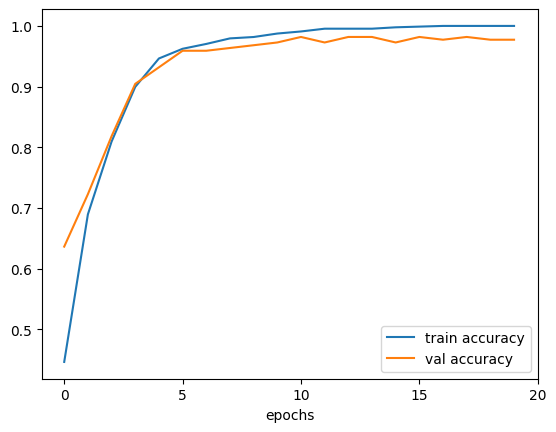

In [ ]:
plt.plot(history.history['accuracy'] , label='train accuracy')
plt.plot(history.history['val_accuracy'] , label ='val accuracy')
plt.legend()
plt.xlabel('epochs')
plt.xticks([0,5,10,15,20])
plt.show()

# Save mode

In [ ]:
model.save('model.h5')
